In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from src.data.datasets import ModelParamsDataset
from src.model.models import MLP
import src.model.train as trainer
from src.config import config as cfg

from tqdm.notebook import tqdm

from dotenv import dotenv_values
from pathlib import Path
import wandb
import random
import string

## Classifiers

Config loaded:
 {'name': 'classifier', 'dataset': {'name': 'eight_angles.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 151, 'hidden_dims': [400, 200], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles.csv


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Train sample: 56000
Validation sample: 16000
Test sample: 8000


wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [10:34<00:00, 12.68s/it]


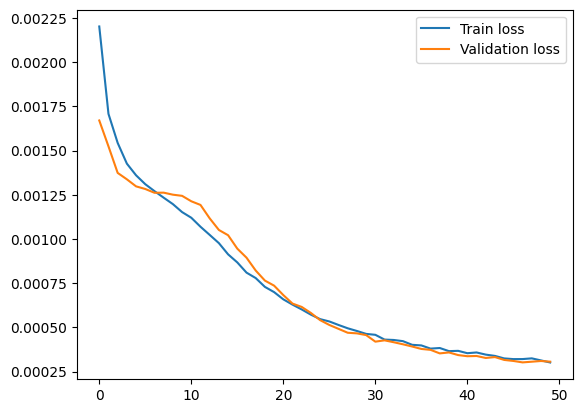

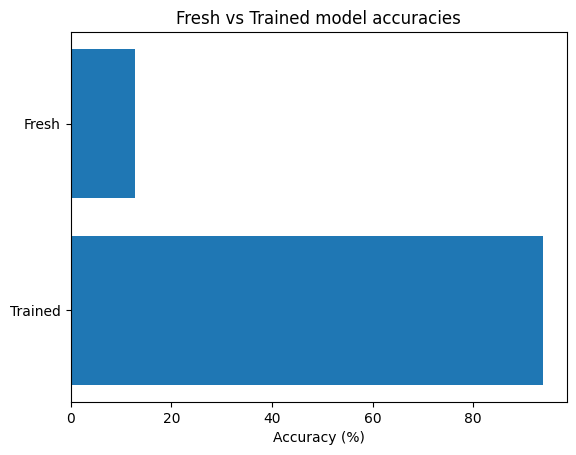

accuracy_trained,▁
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,93.85001
train_loss,0.0003
valid_loss,0.00031


In [3]:
config_name = "classifier_default.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
model_artifact = wandb.Artifact(f"classifier", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)

config_artifact = wandb.Artifact(f"classifier_config", type="config")
config_path = cfg.get_config_path(config_name)
config_artifact.add_file(config_path)
run.log_artifact(config_artifact)

wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

Config loaded:
 {'name': 'classifier_small', 'dataset': {'name': 'eight_angles_small.csv', 'splits': [0.5, 0.25, 0.25], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 20, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 33, 'hidden_dims': [50, 20], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_small.csv
Train sample: 40000
Validation sample: 20000
Test sample: 20000


100%|██████████| 20/20 [01:47<00:00,  5.37s/it]


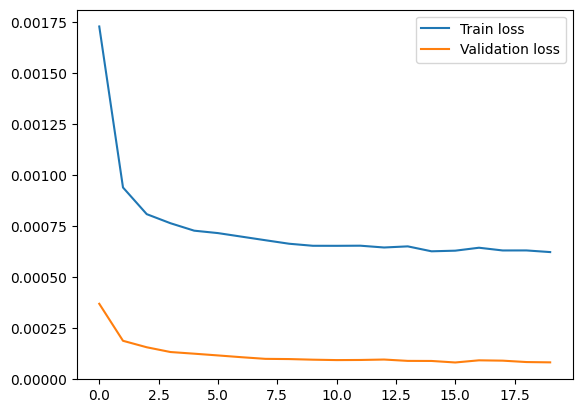

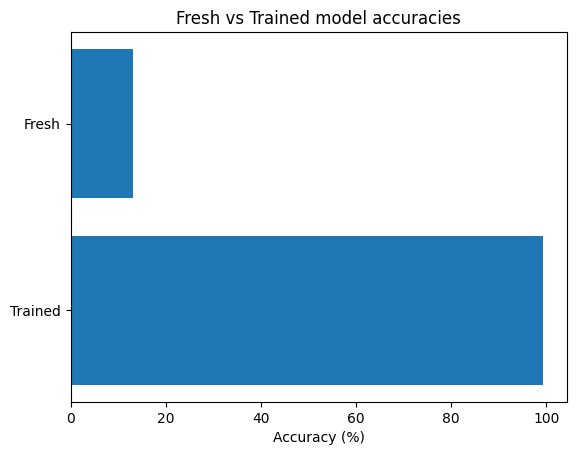

99.30500030517578


In [11]:
config_name = "classifier_small.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
# wandb_config = dotenv_values("../.env")
# run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

# wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()
print(accuracy_trained)

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
# model_artifact = wandb.Artifact(f"classifier", type="model")
# model_artifact.add_file(model_path)
# run.log_artifact(model_artifact)

# config_artifact = wandb.Artifact(f"classifier_config", type="config")
# config_path = cfg.get_config_path(config_name)
# config_artifact.add_file(config_path)
# run.log_artifact(config_artifact)

# wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
# wandb.finish()

## Latent space classifier

Config loaded:
 {'name': 'classifier_small', 'dataset': {'name': 'eight_angles_small_latent.csv', 'splits': [0.7, 0.2, 0.1], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 50, 'learning_rate': 0.0001, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 10, 'hidden_dims': [200, 100], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.4, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_small_latent.csv
Train sample: 56000
Validation sample: 16000
Test sample: 8000


100%|██████████| 50/50 [10:38<00:00, 12.77s/it]


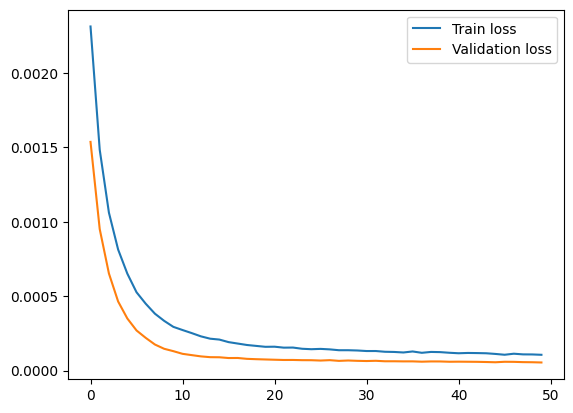

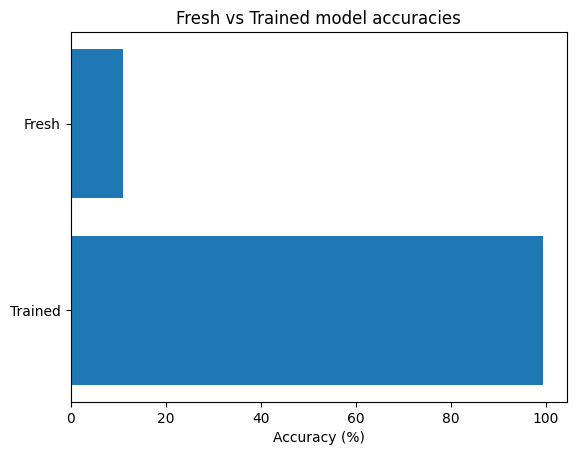

accuracy_trained,▁
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_trained,99.375
train_loss,0.00011
valid_loss,5e-05


In [4]:
config_name = "classifier_latent.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

name = ''.join(random.choices(string.ascii_lowercase, k=7))
name = config["name"]
# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]
batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)
wandb_config = dotenv_values("../.env")
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="weight_classifier_latent")

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()

model_path = models_dir / f"{name}.pth"
torch.save(model.state_dict(), model_path)

# Upload config and model to wandb
model_artifact = wandb.Artifact(f"classifier", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)

config_artifact = wandb.Artifact(f"classifier_config", type="config")
config_path = cfg.get_config_path(config_name)
config_artifact.add_file(config_path)
run.log_artifact(config_artifact)

wandb.alert(title="Model training finished", text=f"Model [{config_name}] training finished successfully.\n Accuracy: {accuracy_trained}")
wandb.finish()

## New

Config loaded:
 {'name': 'classifier_small', 'dataset': {'name': 'eight_angles_small.csv', 'splits': [0.5, 0.25, 0.25], 'batch_size': 128, 'seed': 42}, 'hyperparameters': {'epochs': 20, 'learning_rate': 0.005, 'optimizer': 'adam', 'criterion': 'bce', 'seed': 42}, 'model': {'input_dim': 33, 'hidden_dims': [50, 20], 'output_dim': 8, 'use_batch_norm': True, 'dropout': 0.2, 'output_activation': 'softmax'}}
C:\Projects\Python\master-thesis\data\eight_angles_small.csv
Train sample: 800
Validation sample: 800
Test sample: 78400


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


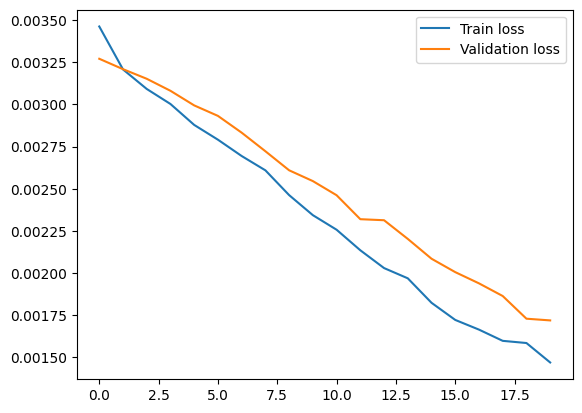

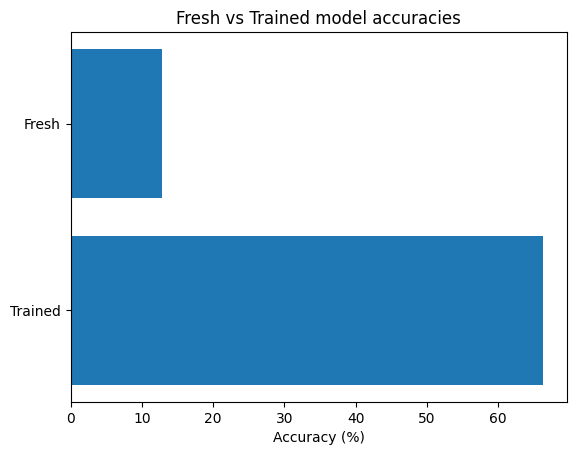

66.26658630371094


In [4]:
config_name = "classifier_small.yaml"
config = cfg.load_config(config_name)
print("Config loaded:\n", config)

default_dirs = cfg.get_default_dirs()
models_dir = Path(default_dirs["models_dir"])
datasets_dir = Path(default_dirs["datasets_dir"])

# Hyperparameters
hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
seed = hyperparameters["seed"]

# Model config
model_config = config["model"]
input_dim = model_config["input_dim"]
hidden_dims = model_config["hidden_dims"]
output_dim = model_config["output_dim"]
dropout = model_config.get("dropout", 0.0)
use_batch_norm = model_config.get("use_batch_norm", False)
output_activation = model_config.get("output_activation", "softmax")

# Load dataset
dataset_config = config["dataset"]
dataset_name = dataset_config["name"]
dataset_splits = dataset_config["splits"]

dataset_splits = [0.01, 0.01, 0.98]

batch_size = dataset_config["batch_size"]
dataset_seed = dataset_config["seed"]

dataset_path = datasets_dir / dataset_name
print(dataset_path)
# Create a dataset
dataset = ModelParamsDataset(dataset_path, 45, get_as_classes=True)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))


torch.manual_seed(seed)

# Init
model = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, valid_losses = trainer.train_mlp(model, epochs, learning_rate, criterion, optimizer, dataloader_train, dataloader_valid)

plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

# Check improvement compared to a fresh model
model_fresh = MLP(input_dim, hidden_dims, output_dim, dropout, use_batch_norm, output_activation)
accuracy_fresh = trainer.get_accuracy(model_fresh, dataloader_test)
accuracy_trained = trainer.get_accuracy(model, dataloader_test)

# wandb.log({"accuracy_trained": accuracy_trained})

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Trained", "Fresh"], [accuracy_trained, accuracy_fresh])
plt.xlabel("Accuracy (%)")
plt.show()
print(accuracy_trained)

# model_path = models_dir / f"{name}.pth"
# torch.save(model.state_dict(), model_path)